# Top 5s

In [137]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil

import math
import numpy as np

from sklearn.metrics import mean_squared_error

#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,2009)]

# CML

In [138]:
max_grade = 1
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 

Conseguir top 5

In [139]:
def get_top(column, yrs):    
    df_acc = pd.DataFrame(columns=["FlightNum", column]).set_index(column)
    for year in yrs:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["FlightNum", column], \
                         encoding="ISO 8859-1")    


        df = df.groupby(by=column).count()
        df_acc = pd.concat([df_acc, df]).groupby(column).sum()
        del df 
    top = df_acc.nlargest(5, 'FlightNum')
    return top

Crear directorio con data de delays agrupada por filter_column 

In [140]:
def create_grouped_files(subdir, years, subset, filter_column):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    
    df_cut = pd.DataFrame(columns=["date", filter_column, "ArrDelay"])
    df_full = pd.DataFrame(columns=["date", filter_column, "ArrDelay"])
    for year in years:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "ArrDelay", filter_column], \
                         encoding="ISO 8859-1")    

        #solo los del valor pedido
        df = df.loc[df[filter_column].isin(subset)]

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
        df["date"] = dates

        #acumulamos en full antes de recortar outliers
        df = df[["date", "ArrDelay", filter_column]]
        dg = df.groupby(
                [pd.Grouper(key='date', freq='M'), pd.Grouper(key=filter_column)] 
            ).mean().reset_index()

        df_full = pd.concat([df_full, dg], sort=False)
        
        #sacamos outliers
        low = 0.1
        high = 0.9

        group = [pd.Grouper(key='date', freq='M'), pd.Grouper(key=filter_column)]
        df = df.groupby(group) \
                .apply(lambda x : 
                  x[(x.ArrDelay >= x.ArrDelay.quantile(low)) & 
                    (x.ArrDelay <= x.ArrDelay.quantile(high))]
              .mean()
              ).reset_index()
        
        if (year==1994):
            print(df)
        
        df_cut = pd.concat([df_cut, df], sort=False)
        del df 

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

Plotear datos

In [141]:
def plot_df(df1, df2, train_limit_axis, unit_str):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))
    
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay')
    df2.ArrDelay.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

max_grade = 0    
def plot_top(top_rank, entity_name, subdir, filter_column):
    for entity in top_rank:
        print("{}: {}".format(entity_name.capitalize(), entity))

        df_full = pd.read_csv(tmp_dir+subdir+"/full.csv")
        df_full = df_full[df_full[filter_column] == entity]
        df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
        
        #probamos sin outliers y con outliers
        for trim in ["cut", "full"]:
            print("Trim: {}".format(trim))
            df = pd.read_csv("{}{}/{}.csv".format(tmp_dir, subdir, trim))
            df = df[df[filter_column] == entity]
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df.sort_values(by="date")

            year_train_limit = 1998
            lower_year_train_limit = 1993
            train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                                  (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]

            lpr = lsqPredictor(phases, monthly_freqs, max_grade)
            lpr.fit(train_delays)
            #lpr.print_coefs()

            train_test_delays = df["ArrDelay"]
            df["dl_pred"] = lpr.pred(train_test_delays)
            plot_df(df.reset_index(), df_full.reset_index(), len(train_delays), "mes")

            error = math.sqrt(
                mean_squared_error(
                    df.loc[df["date"].dt.year > year_train_limit].dl_pred, 
                    df_full.loc[df_full["date"].dt.year > year_train_limit].ArrDelay
                )
            )
            print(error)
            del df
        del df_full

## Top 5 aerolíneas

In [ ]:
years = [str(year) for year in range(1994,2000)]
df = get_top("UniqueCarrier", years)

if not os.path.exists(tmp_dir+"carriers/"):
    os.makedirs(tmp_dir+"carriers/")
        
df.to_csv(top_carriers.csv")
df

In [ ]:
df.to_csv(tmp_dir+"carriers/top_carriers.csv")

In [51]:
df = pd.read_csv(tmp_dir+"carriers/top_carriers.csv")

In [52]:
top_carriers = df.reset_index()["UniqueCarrier"]
top_carriers

0    DL
1    US
2    WN
3    UA
4    AA
Name: UniqueCarrier, dtype: object

In [ ]:
years = [str(year) for year in range(1994, 2009)]
create_grouped_files("carriers/", years, top_carriers, "UniqueCarrier")

Carrier: DL
Trim: cut


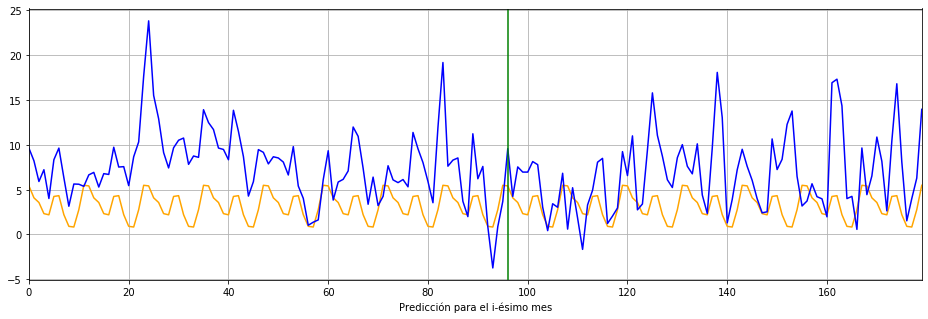

5.699651899901703
Trim: full


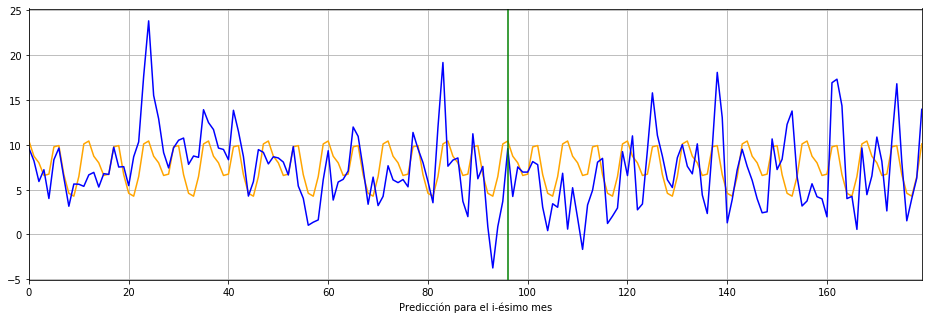

4.207991190853204
Carrier: US
Trim: cut


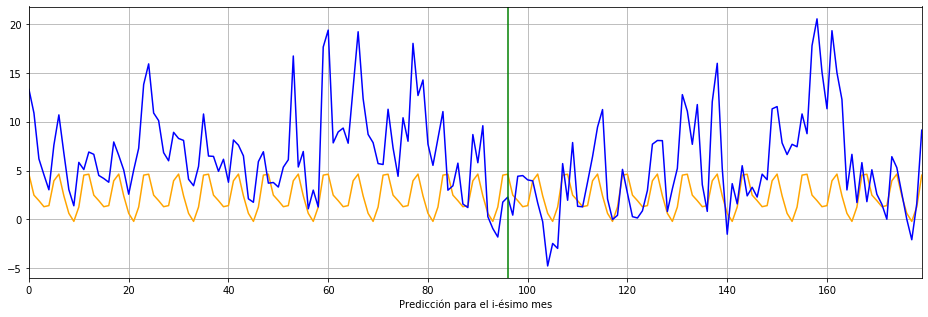

5.858539977851012
Trim: full


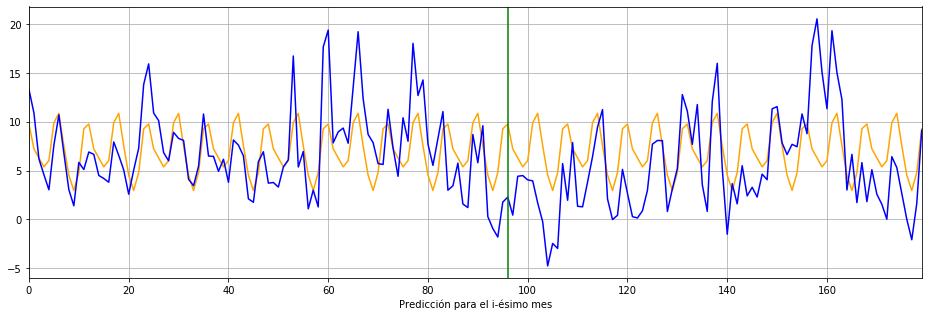

4.619629643895246
Carrier: WN
Trim: cut


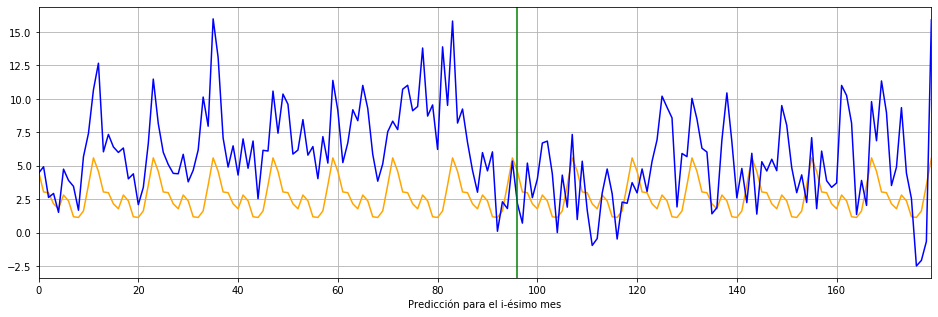

3.9903419064750265
Trim: full


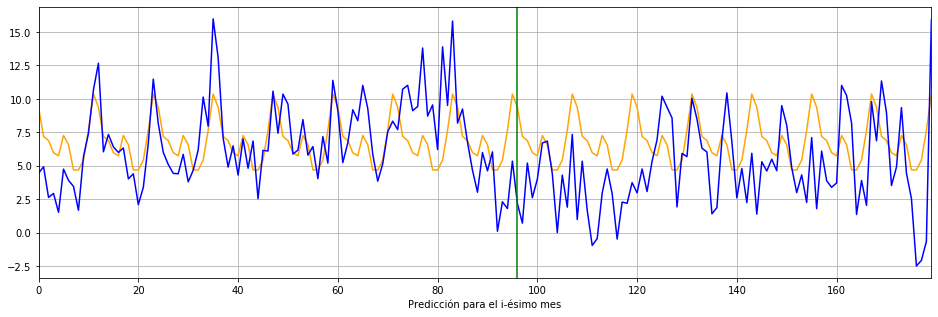

3.8773360906271916
Carrier: UA
Trim: cut


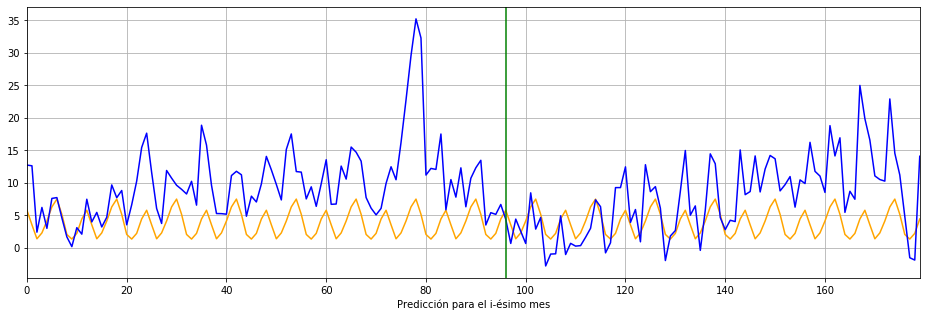

7.059926883953418
Trim: full


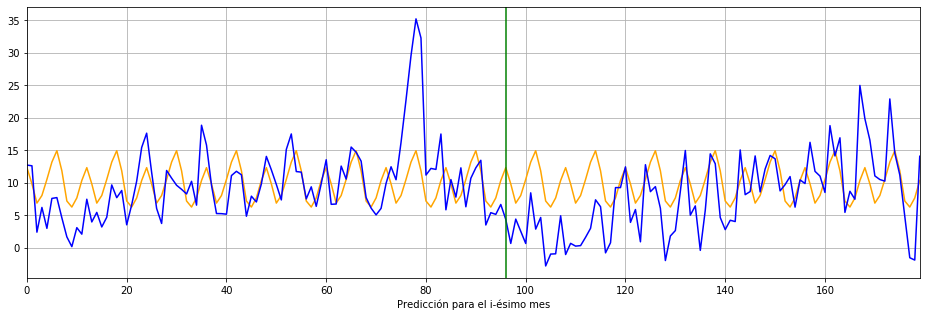

5.4655217135146374
Carrier: AA
Trim: cut


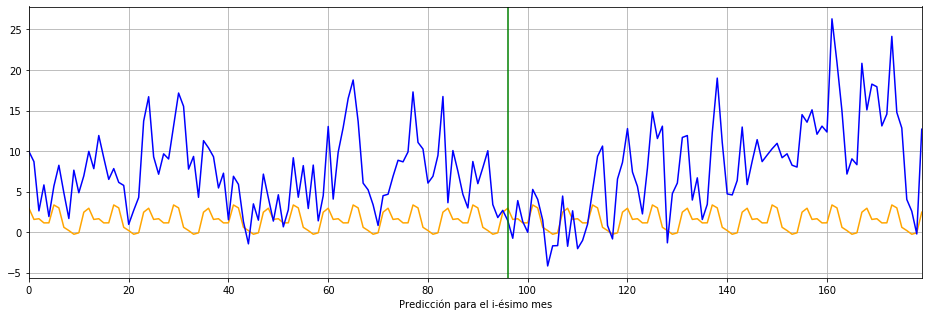

9.646139258948097
Trim: full


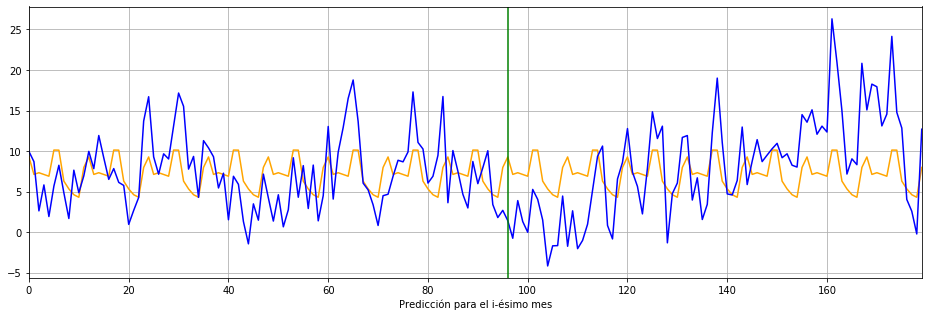

5.8161342964633835


In [57]:
plot_top(top_carriers, "Carrier", "carriers/", "UniqueCarrier")

## Top 5 aeropuertos

In [ ]:
years = [str(year) for year in range(1994,2000)]

df = get_top("Origin", years)

if not os.path.exists(tmp_dir+"airports/"):
    os.makedirs(tmp_dir+"airports/")
                    
df.to_csv(tmp_dir+"airports/top_airports.csv")
df

In [8]:
df = pd.read_csv(tmp_dir+"airports/top_airports.csv")
top_airports = df.reset_index()["Origin"]
top_airports

0    ORD
1    DFW
2    ATL
3    LAX
4    STL
Name: Origin, dtype: object

#### Conseguir sus vuelos

In [ ]:
years = [str(year) for year in range(1994,2000)]
create_grouped_files("airports/", years, top_airports, "Origin")

Airport: ORD
Trim: cut


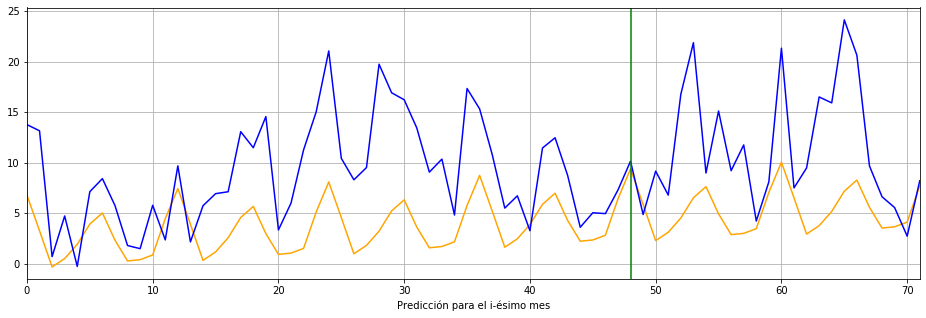

8.760882087497532
Trim: full


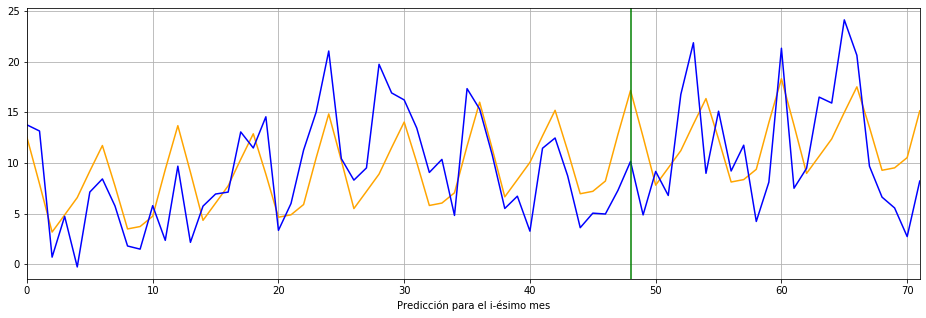

5.277120206850327
Airport: DFW
Trim: cut


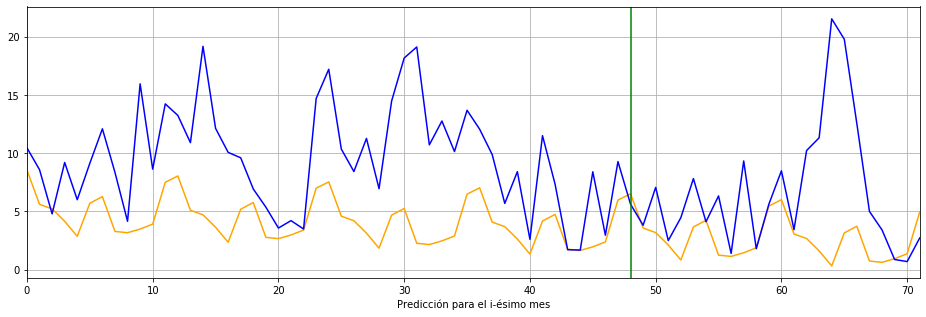

9.0828353032191
Trim: full


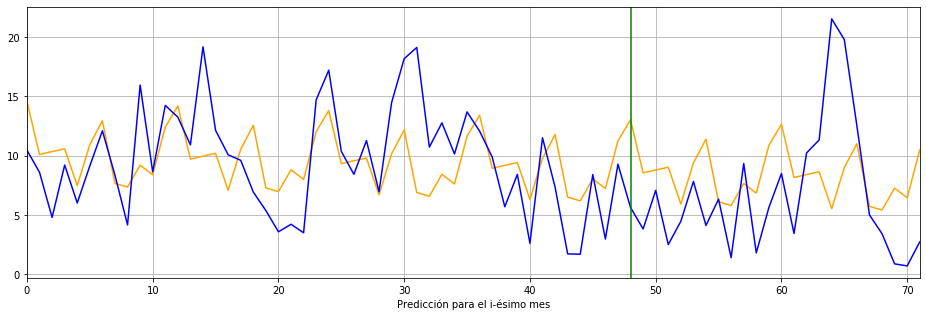

6.841744612625271
Airport: ATL
Trim: cut


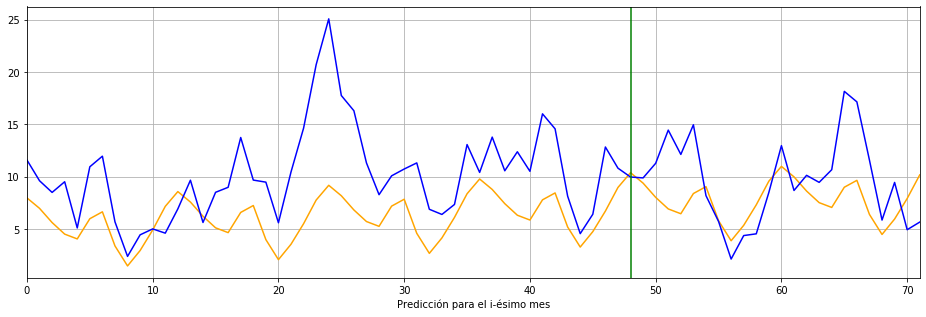

4.429095524316808
Trim: full


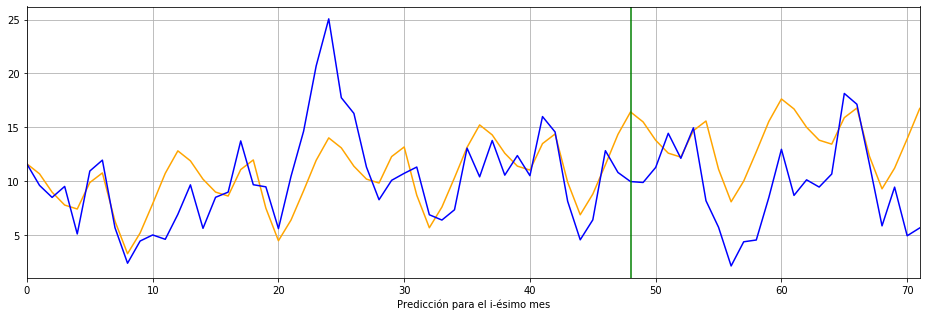

5.49408198675471
Airport: LAX
Trim: cut


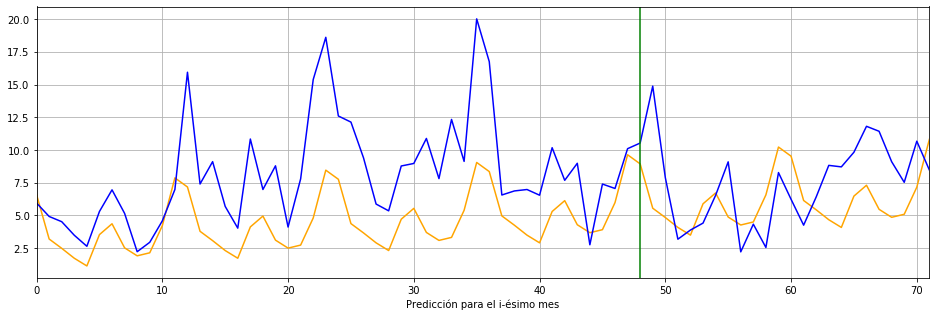

3.6849483765739204
Trim: full


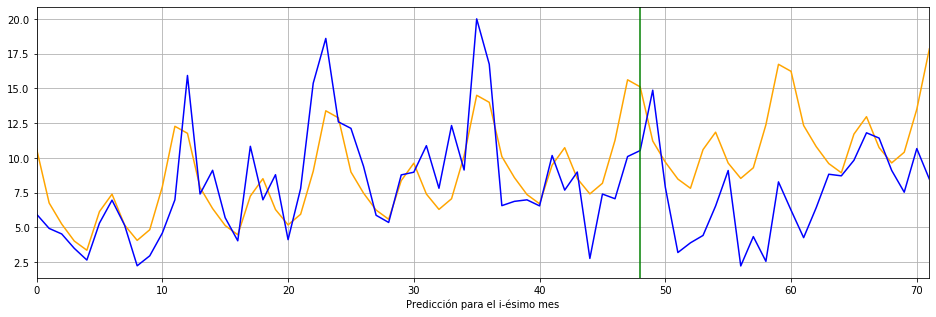

4.962535237870804
Airport: STL
Trim: cut


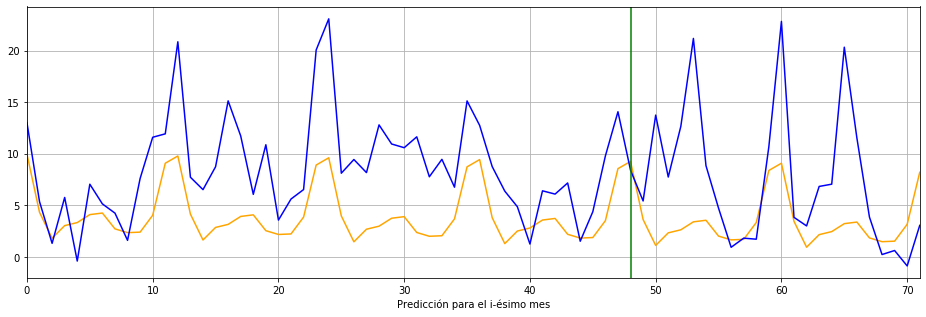

7.327803309293335
Trim: full


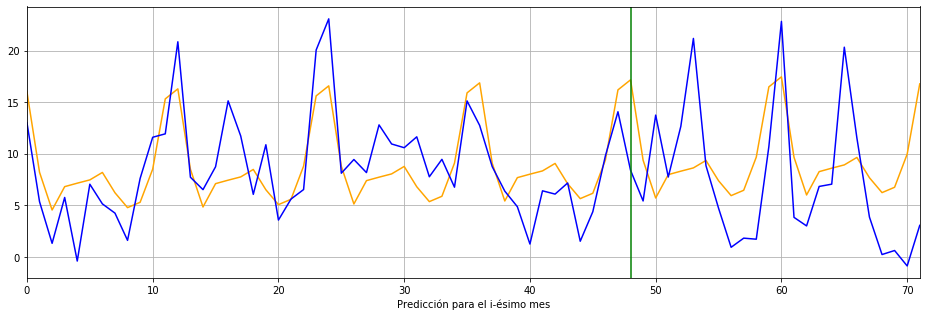

7.09240981254546


In [16]:
max_grade = 1
plot_top(top_airports, "Airport", "airports/", "Origin")

In [44]:
def get_top_routes(yrs):    
    df_acc = pd.DataFrame(columns=["FlightNum", "origin_city", "dest_city"]).set_index(["origin_city", "dest_city"])
    df_cities = pd.read_csv("../data/airports.csv", usecols=["city", "iata"])
    origin_df = df_cities.rename(columns={"city": "origin_city", "iata": "origin_iata"})  
    dest_df = df_cities.rename(columns={"city": "dest_city", "iata": "dest_iata"})  
    
    for year in yrs:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["FlightNum", "Origin", "Dest"], \
                         encoding="ISO 8859-1")    
        
        #agrego las ciudades
        df = df.merge(origin_df, left_on='Origin', right_on='origin_iata')
        df = df.merge(dest_df, left_on='Dest', right_on='dest_iata')
        
        #ciudades que mas aparecen
        df = df.groupby(["origin_city", "dest_city"]).count()
        df_acc = pd.concat([df_acc, df], join="inner").groupby(["origin_city", "dest_city"]).sum()
        del df 
    top = df_acc.nlargest(5, 'FlightNum')
    return top

In [45]:
years = [str(y) for y in range(1994, 2000)]
top_routes = get_top_routes(years)

Leyendo csv: 1994
Leyendo csv: 1995
Leyendo csv: 1996
Leyendo csv: 1997
Leyendo csv: 1998
Leyendo csv: 1999


In [66]:
top_routes.reset_index()
print(top_routes)

                             FlightNum
origin_city   dest_city               
Los Angeles   San Francisco     100857
San Francisco Los Angeles       100583
Chicago       Minneapolis       100098
Minneapolis   Chicago            99963
Los Angeles   Las Vegas          96728


In [119]:
def create_cities_grouped_files(subdir, years):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    
    df_cut = pd.DataFrame(columns=["date", "dest_city", "origin_city", "ArrDelay"])
    df_full = pd.DataFrame(columns=["date", "dest_city", "origin_city", "ArrDelay"])
    
    df_cities = pd.read_csv("../data/airports.csv", usecols=["city", "iata"])
    origin_df = df_cities.rename(columns={"city": "origin_city", "iata": "origin_iata"})  
    dest_df = df_cities.rename(columns={"city": "dest_city", "iata": "dest_iata"})  
    
    routes = top_routes.reset_index()
    routes = routes[["origin_city", "dest_city"]]
    
    for year in years:
        print("Leyendo csv: {}".format(year))
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "ArrDelay", "Origin", "Dest"], \
                         encoding="ISO 8859-1")    

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
        df["date"] = dates
        df = df[["date", "ArrDelay", "Origin", "Dest"]]

        #agrego las ciudades
        df = df.merge(origin_df, left_on='Origin', right_on='origin_iata')
        df = df.merge(dest_df, left_on='Dest', right_on='dest_iata')
        df = df[["date", "ArrDelay", "origin_city", "dest_city"]]
        
        #solo los del valor pedido
        df = df.merge(routes, how="inner")
        #acumulamos en full antes de recortar outliers
        dg = df.groupby(
                [pd.Grouper(key='date', freq='M'), pd.Grouper(key="origin_city"),  pd.Grouper(key="dest_city")] 
            ).mean().reset_index()
        
        df_full = pd.concat([df_full, dg], join="outer" , sort=False)
        
        #sacamos outliers
        low = 0.1
        high = 0.9

        group = [pd.Grouper(key='date', freq='M'), pd.Grouper(key="origin_city"),  pd.Grouper(key="dest_city")]
        df = df.groupby(group) \
                .apply(lambda x : 
                  x[(x.ArrDelay >= x.ArrDelay.quantile(low)) & 
                    (x.ArrDelay <= x.ArrDelay.quantile(high))]
              .mean()
              ).reset_index()
        
        if (year==1994):
            print(df)
    
        df_cut = pd.concat([df_cut, df], join="outer" , sort=False)
        del df 

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

years = [str(y) for y in range(1994, 2002)]
create_cities_grouped_files("cities/", years)

Leyendo csv: 1994
Leyendo csv: 1995
Leyendo csv: 1996
Leyendo csv: 1997
Leyendo csv: 1998
Leyendo csv: 1999
Leyendo csv: 2000
Leyendo csv: 2001


In [142]:
max_grade = 0    
def plot_top_cities(top_rank, subdir):
    for [src_city, dest_city] in top_rank:
        print("Cities: {}->{}".format(src_city, dest_city))

        df_full = pd.read_csv(tmp_dir+subdir+"/full.csv")
        df_full = df_full[(df_full.origin_city == src_city) & (df_full.dest_city == dest_city)]
        df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
        
        #probamos sin outliers y con outliers
        for trim in ["cut", "full"]:
            print("Trim: {}".format(trim))
            df = pd.read_csv("{}{}/{}.csv".format(tmp_dir, subdir, trim))
            df = df[(df.origin_city == src_city) & (df.dest_city == dest_city)]
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df.sort_values(by="date")

            year_train_limit = 1998
            lower_year_train_limit = 1993
            train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                                  (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]

            lpr = lsqPredictor(phases, monthly_freqs, max_grade)
            lpr.fit(train_delays)
            #lpr.print_coefs()

            train_test_delays = df["ArrDelay"]
            df["dl_pred"] = lpr.pred(train_test_delays)
            plot_df(df.reset_index(), df_full.reset_index(), len(train_delays), "mes")

            error = math.sqrt(
                mean_squared_error(
                    df.loc[df["date"].dt.year > year_train_limit].dl_pred, 
                    df_full.loc[df_full["date"].dt.year > year_train_limit].ArrDelay
                )
            )
            print(error)
            del df
        del df_full

[['Los Angeles' 'San Francisco']
 ['San Francisco' 'Los Angeles']
 ['Chicago' 'Minneapolis']
 ['Minneapolis' 'Chicago']
 ['Los Angeles' 'Las Vegas']]
Cities: Los Angeles->San Francisco
Trim: cut


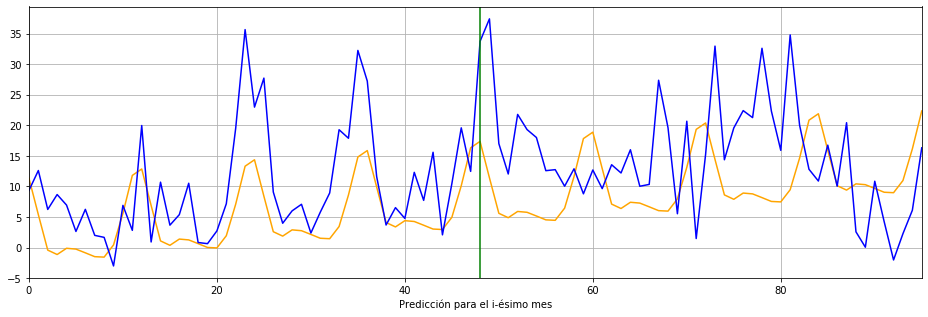

11.18845205004715
Trim: full


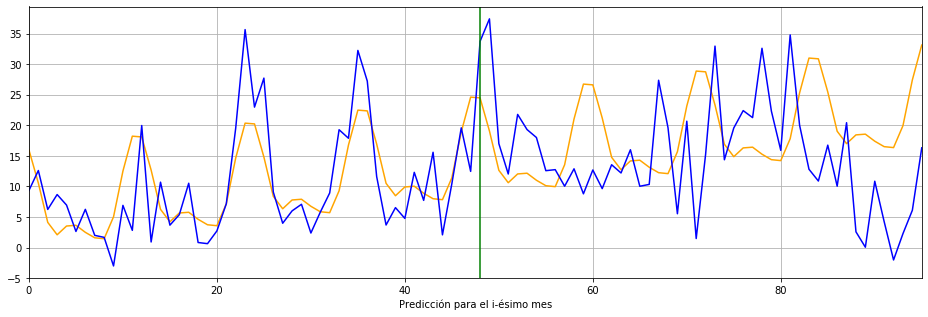

12.495836766735929
Cities: San Francisco->Los Angeles
Trim: cut


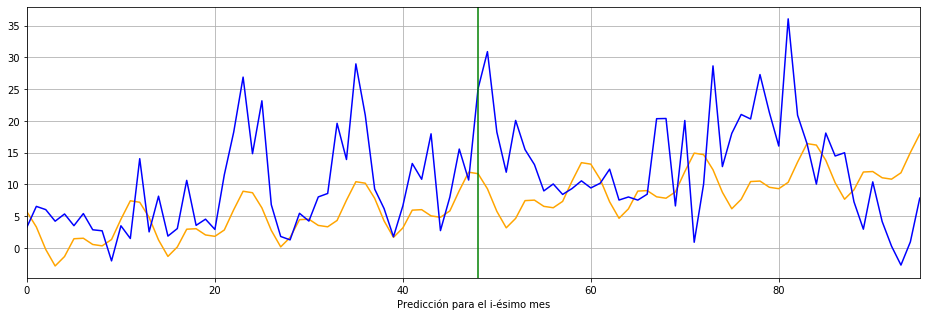

9.742414337503845
Trim: full


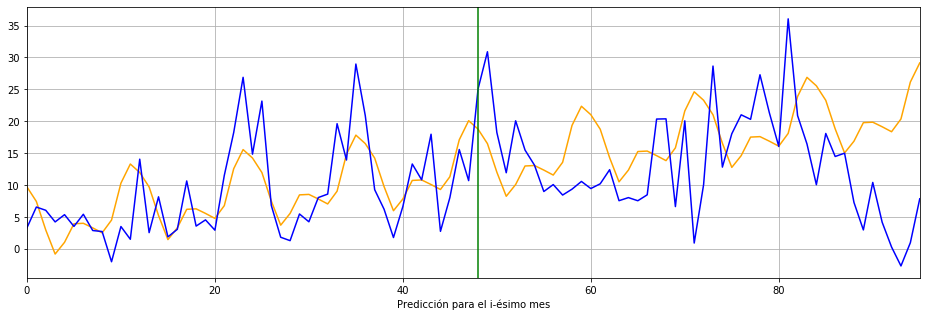

11.635095038714162
Cities: Chicago->Minneapolis
Trim: cut


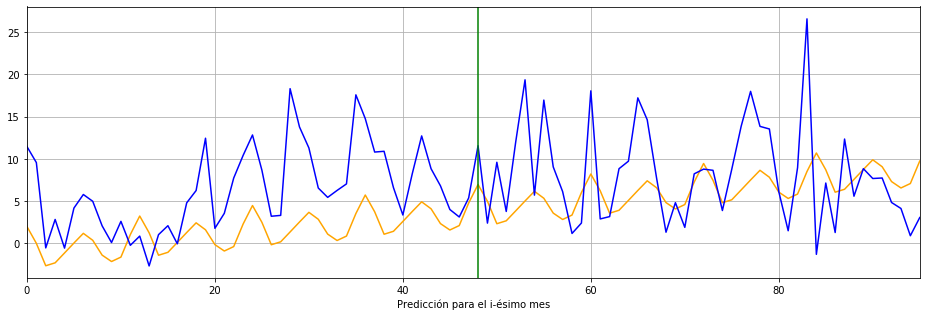

5.895836413117478
Trim: full


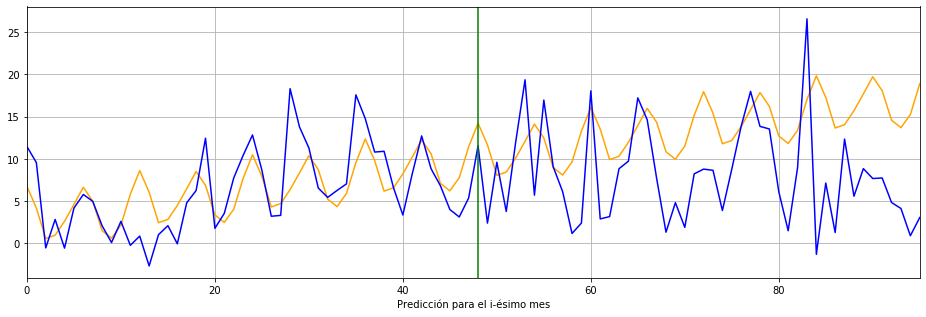

8.747334197125785
Cities: Minneapolis->Chicago
Trim: cut


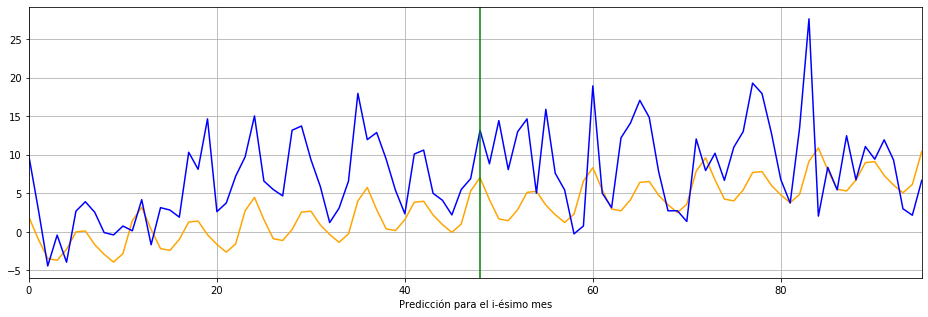

6.547368323662398
Trim: full


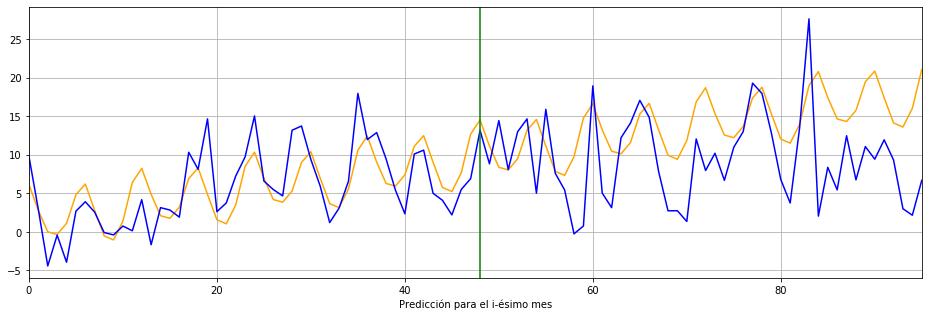

7.674108490349182
Cities: Los Angeles->Las Vegas
Trim: cut


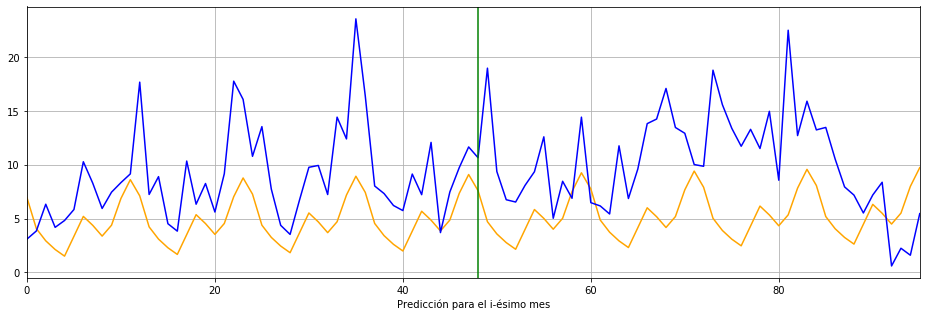

7.291746404187015
Trim: full


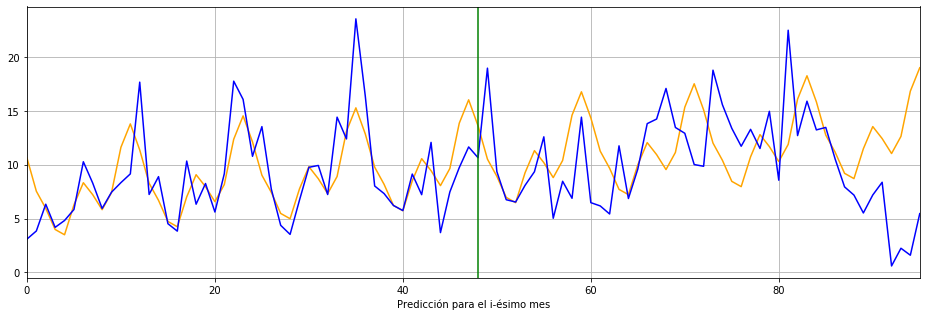

5.979078387017117


In [143]:
max_grade = 1
routes = top_routes.reset_index()[["origin_city", "dest_city"]].values
print(routes)
plot_top_cities(routes, "cities/")